<a href="https://colab.research.google.com/github/arash-am/Media-Competition/blob/main/Main/In_order/Figure3_Limited_action.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

In [1]:
import numpy as np # used for arrays
import gym # pull the environment
import time # to get the time
import math # needed for calculations
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from collections import deque


In [2]:
#########################################################################################################################################################################
class replay_buffer(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque(maxlen=self.capacity)

    def store(self, observation, action, reward, next_observation, done):
        observation = np.expand_dims(observation, 0)
        next_observation = np.expand_dims(next_observation, 0)
        self.memory.append([observation, action, reward, next_observation, done])

    def sample(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        observations, actions, rewards, next_observations, dones = zip(* batch)
        return np.concatenate(observations, 0), actions, rewards, np.concatenate(next_observations, 0), dones

    def __len__(self):
        return len(self.memory)

#########################################################################################################################################################################

class soft_q_net(nn.Module):
    def __init__(self, observation_dim,bpl,bop,M,action_dim=9):
        super(soft_q_net, self).__init__()
        self.observation_dim = observation_dim
        self.bpl = bpl
        self.bop = bop
        self.action_dim=action_dim
        self.M=M
        self.makspl=torch.zeros(action_dim,action_dim)
        self.maksop=torch.zeros(action_dim,action_dim)
        for i in range(action_dim):
            self.makspl[i,:]=i*action_dim+torch.arange(action_dim)
        for i in range(action_dim):
            self.maksop[i,:]=action_dim*torch.arange(action_dim)+i
                # Using The initialization & incorporating batch normalization
        self.fc1 = nn.Linear(self.observation_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, self.action_dim**2)

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                m.weight.data.fill_(0.0)  # Set all weights to zero
                if m.bias is not None:
                    m.bias.data.fill_(0.0)  # Keep bias initialization as is, setting to zero


    def forward(self, observation):
        x = self.fc1(observation)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

# Translate this to batchwise results -----------------------------------------------------------------------------

    def log_sum_exp(self,x):
        max_x=x.max(dim=1,keepdim=True)[0]
        exps = torch.exp(x - max_x)
        sum_of_exps = exps.sum(dim=-1)
        return torch.log(sum_of_exps) + max_x.squeeze()

    def getV(self, q_value):
        Q_pl=self.getQ_pl(q_value)
        v = (1/self.bpl) * (self.log_sum_exp(self.bpl * Q_pl)-torch.log(torch.tensor(self.action_dim)))
        return v


    # consider uniform policies
    def getQ_pl(self, q_value):
        Qa=torch.zeros((q_value.shape[0],self.action_dim,))
        for i in range(self.action_dim):
            x=self.bop*q_value[:,self.makspl[i,:].int()]
            Qa[:,i]=(1/self.bop)*(self.log_sum_exp(x)-torch.log(torch.tensor(self.action_dim)))
        Q_pl=Qa
        return Q_pl



    def getQ_op(self, q_value):
        Qa=torch.zeros((q_value.shape[0],self.action_dim,))
        for i in range(self.action_dim):
            x=self.bpl*q_value[:,self.maksop[i,:].int()]
            Qa[:,i]=(1/self.bpl)*(self.log_sum_exp(x)-torch.log(torch.tensor(self.action_dim)))
            # Qa[:,i]=((self.bpl*q_value[:,self.maksop[i,:].int()].squeeze()).exp()).sum(dim=-1)/(self.action_dim)
        # Q_op = (1/self.bpl) * Qa.log()
        Q_op=Qa
        return Q_op

# Correct the action spapce
    def act(self, observation):
        with torch.no_grad():
            # observation = torch.FloatTensor(np.expand_dims(obs, 0))
            q_value = self.forward(observation)
            Q_pl=self.getQ_pl(q_value)
            Q_op=self.getQ_op(q_value)
            pi_pl=F.softmax(self.bpl*Q_pl, dim=-1)
            pi_op=F.softmax(self.bop*Q_op, dim=-1)
            dist_pl = torch.distributions.Categorical(pi_pl)
            dist_op = torch.distributions.Categorical(pi_op)
            ac_pl=dist_pl.sample().item()
            ac_op=dist_op.sample().item()
            ac_id=ac_pl*self.action_dim+ac_op
        return ac_pl, ac_op,ac_id,torch.cat([pi_pl,pi_op])


####################################################################################


def train(buffer, target_model, eval_model, gamma, optimizer, batch_size, loss_fn, count, update_freq,TAU):
      observation, action, reward, next_observation, done = buffer.sample(batch_size)
      observation = torch.FloatTensor(observation.squeeze())
      action = torch.LongTensor(action)
      reward = torch.FloatTensor(reward)
      next_observation = torch.FloatTensor(next_observation.squeeze())
      done = torch.FloatTensor(done)
      # print(observation.shape)

      q_values = eval_model.forward(observation)
      next_q_values = target_net.forward(next_observation)
      next_v_values = target_net.getV(next_q_values)
      q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
      expected_q_value = reward + gamma * (1 - done) * next_v_values.squeeze(-1)
      loss = (expected_q_value.detach() - q_value).pow(2)
      loss = loss.mean()
      optimizer.zero_grad()
      loss.backward()
      # if count % 1000 == 0:
      #   with torch.no_grad():
            # print(f'State diffrence Q: {q_values.var(dim=0).max():.1e},\t action diffrence Q: {q_values.var(dim=1).max():.1e}')
      # torch.nn.utils.clip_grad_norm_(eval_model.parameters(), max_norm=1)
      optimizer.step()
      # if count % (1*10**5) == 0:
      #     target_net.load_state_dict(eval_model.state_dict())
      #     print(100*'*','New Target Network',100*'*')
      # Soft update of the target network's weights
      # θ ← τ θ' + (1 −τ )θ′
      target_net_state_dict = target_model.state_dict()
      policy_net_state_dict = eval_model.state_dict()
      for key in policy_net_state_dict:
          target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
      target_model.load_state_dict(target_net_state_dict)
      with torch.no_grad():
        loss_p=((expected_q_value.detach() - q_value).pow(2).mean())
        loss_n=loss_p/q_value.var()
      return loss_p,loss_n,next_q_values




In [3]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from collections import deque

class Opinon_w_media_9(torch.nn.Module):
    def __init__(self, device, N=1000, M=10, terminal_time=500,
                 bM=5, b=25, noise_level=0.1, duration=50, eta=1, eta2=2,
                 h=torch.tensor(0.1),num_batches=10,bet1=3,bet2=2,nbins=50,scale=10):
        super().__init__()
        self.batch_size = num_batches
        self.device = device
        self.N = N
        self.M = M
        self.terminal_time = terminal_time
        Beta = torch.distributions.beta.Beta(bet1, bet2)
        self.s = Beta.sample(sample_shape=(self.N,self.batch_size)).to(self.device)
        self.ym = torch.linspace(-1, 1, steps=self.M).to(self.device)
        self.noise_level = noise_level
        self.bM = bM
        self.b = b
        self.duration = duration
        self.eta = eta
        self.eta2 = eta2
        self.h = h.to(self.device)
        self.t=0
        self.action_dim=9
        self.pi=torch.tensor(np.pi,device=self.device)
        self.nbins=nbins
        self.scale=scale

    def action_list(self, action_ids):
        zm = torch.linspace(0, 1, steps=int(self.M/2)).to(self.device)
        # action_ids = action_ids.unsqueeze(1)
        probabilities = torch.tensor([.95, .95, .95, .5, .5, .1, .1, .5, .1], device=self.device)
        deltas = torch.tensor([.000001, .85, .45, -.00001, -.45, -.85, -.0000001, .4, -.4], device=self.device)
        base_probs = probabilities[action_ids].squeeze()
        delta_probs = deltas[action_ids].squeeze()
        return torch.bernoulli(base_probs-zm[:,None]*delta_probs)


    def reset(self):
        self.state = torch.cat([torch.rand((self.N,self.batch_size), device=self.device) * 2 - 1,
                                torch.ones((self.M,self.batch_size), device=self.device)])
        self.t=0
        self.AEm=torch.zeros((self.N,self.batch_size,self.M),device=self.device)
        self.X=torch.zeros((self.terminal_time,self.N,self.batch_size),device=self.device)
        self.C=torch.zeros((self.terminal_time,self.M,self.batch_size),device=self.device)
        return self.state

    def dyn_step(self, u_action_ids, v_action_ids):
        rewards = torch.zeros((self.batch_size,), device=self.device)
        dones = torch.zeros((self.batch_size,), device=self.device, dtype=torch.bool)
        x, c= self.state[:self.N], self.state[self.N:]
        t=self.t
        gam=0.98
        rewards=0
        for i in range(self.duration):
            self.X[t,:,:]=x
            self.C[t,:,:]=c
          # Add exposure
            DM = self.ym-x[:,:,None]
            D = x - x[:, None]
            u_actions = self.action_list(u_action_ids).t()
            v_actions = self.action_list(v_action_ids).t()
            actions = torch.cat([u_actions, v_actions],dim=1)
            eta = self.eta
            eta2 = self.eta2
            AM = torch.exp(-self.bM * (1 + eta * actions[None,:,:]) * (1 + eta2 * (1 - c.t()[None,:,:])*(1-self.s[:,:,None])) * torch.abs(DM))
            A = torch.exp(-self.b * torch.abs(D))
            t += 1
            c= c*(gam)+actions.t()*(1-gam)
            x += self.h * ((torch.sum(A * D, dim=1) / torch.sum(A, dim=1)) + (torch.sum(AM * DM, dim=2) / torch.sum(AM, dim=2)))
            x += torch.sqrt(self.h) * torch.normal(0, self.noise_level, size=(self.N,self.batch_size), device=self.device)
            rewards = 0.95*rewards -self.scale*torch.sin(x*self.pi/2).pow(5).mean().to(self.device)
            self.AEm += torch.exp(-self.bM * torch.abs(DM))* (1-actions[None,:,:])
        self.state=torch.cat([x,c])
        self.t=t
        dones = dones | (t >= self.terminal_time)
        return rewards/self.duration, dones
    def state2obs(self,state):
        obs=torch.zeros((self.nbins+self.M,self.batch_size),device=device)
        for i in range(self.batch_size):
            xs=state[:self.N,i].clone().detach()
            cs=state[self.N:self.N+self.M,i].clone().detach()
            obs[:,i]=torch.cat([1*torch.histc(xs, bins=self.nbins, min=-1, max=1)/self.N, cs])
        return obs


In [8]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
torch.set_printoptions(linewidth=1000)



nbins=30
M=10
N=500
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
terminal_time=200
Duration=1
env = Opinon_w_media_9(device=device, N=N,
                                M=M, terminal_time=terminal_time,bM=5,b=20,noise_level=0.1,
                                duration=Duration,h=torch.tensor(.1),
                                num_batches=1,eta=1, eta2=2,
                                bet1=3,bet2=2,nbins=nbins,scale=10)
env.reset()

# reward, done =


env.reset()
gamma = 0.95
learning_rate = 1e-4
train_batch_size = 64
update_freq = 100
capacity = 2*10**6
render = False
episode = 50000
observation_dim = nbins+M
bpl=10
bop=-10
TAU=0.001
action_dimension=9
target_net = soft_q_net(observation_dim, bpl,bop,M,action_dimension )
eval_net = soft_q_net(observation_dim, bpl,bop,M,action_dimension )
eval_net.load_state_dict(target_net.state_dict())
optimizer = torch.optim.Adam(eval_net.parameters(), lr=learning_rate)
buffer = replay_buffer(capacity)
loss_fn = nn.MSELoss()
count = 0
reward_total = 0
loss_p=-1
epoch=0
Loss=[]

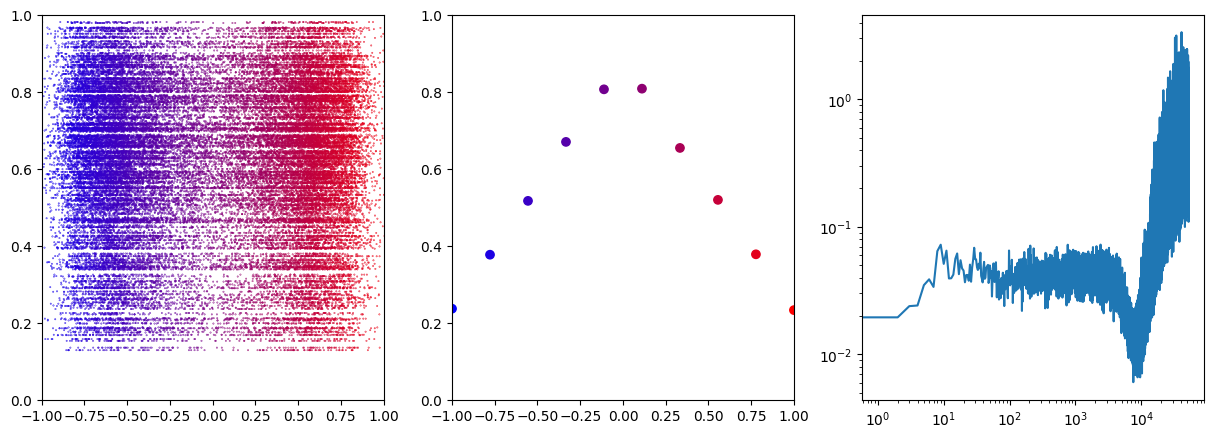

Epoch:	 52300, Episode: 50000
Loss:	 2.018e-01
average reward:	 1.008721947669983


KeyboardInterrupt: 

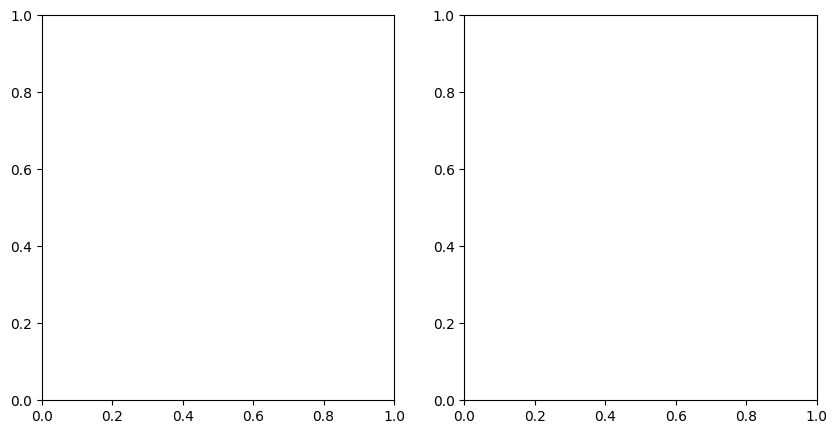

In [9]:
from google.colab import drive
drive.mount('/content/gdrive')
from IPython.display import display, clear_output
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list("custom_blue_red", [(0, 0, 1), (1, 0, 0)], N=100)
fig,ax=plt.subplots(1,2,figsize=(10,5))
X=[]
C=[]

Tr=0


for i in range(10**6):
    xct=env.reset()
    obs = env.state2obs(xct)
    reward_total=0
    while True:
        u_action, v_action,action_id,action_dist = eval_net.act(obs.t())
        count += 1
        reward, Done  =env.dyn_step(torch.tensor(u_action,device=env.device),torch.tensor(v_action,device=env.device))
        next_obs = env.state2obs(env.state)
        buffer.store(obs, action_id, reward, next_obs, Done)
        reward_total =reward_total + reward
        obs = next_obs
        if Done:
            X.append(env.state[:env.N].cpu().squeeze().numpy())
            C.append(env.state[env.N:].cpu().squeeze().numpy())
            Tr+=reward_total
            break
    if len(buffer.memory) > train_batch_size:
            epoch+=1
            loss_p,loss_q,_=train(buffer, target_net, eval_net, gamma, optimizer, train_batch_size, loss_fn, count, update_freq,TAU)
            Loss.append(loss_p.item())
            if epoch%100==0:
                fig, ax = plt.subplots(1, 3, figsize=(15, 5))
                ax[0].scatter(x=np.array(X)[:].flatten(), y=np.repeat(env.s.squeeze(),np.array(X).shape[0]), c=np.array(X)[:].flatten(),s=.1, cmap=cmap,alpha=1)
                ax[0].set_ylim(0, 1)
                ax[0].set_xlim(-1, 1)
                ax[1].scatter(x=np.linspace(-1, 1, env.M), y=np.array(C).mean(axis=0), c=np.linspace(-1, 1, env.M), cmap=cmap)
                ax[1].set_ylim(0, 1)
                ax[1].set_xlim(-1, 1)
                ax[2].loglog(np.array(Loss))
                clear_output(wait=True)  # Clear the output of the existing plot before redrawing
                display(plt.gcf())  # Display the current figure
                print(f'Epoch:\t {epoch}, Episode: {episode}')
                print(f'Loss:\t {loss_p:.3e}')
                print(f'average reward:\t {Tr/np.array(X).shape[0]}')
                plt.close(fig)  # Close the figure to free resource
                X=[]
                C=[]
                Tr=0
                save_path='/content/gdrive/My Drive/UT/Data/9_action_200_interval_final'+str(M)+'_b'+str(bpl)+'_D'+str(Duration)
                save_filename = f'target_net.pt'  # Name the file indicating it's the best model so far
                torch.save(target_net.state_dict(), save_path + save_filename)
                test_net=soft_q_net(observation_dim, bpl,bop,M,action_dimension )


# Plots

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
count= 1005,	 Mean reward: 35.605, 	 total reward: -14.192


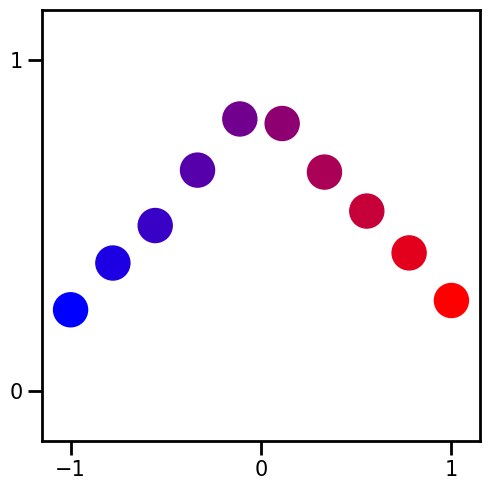

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')
from IPython.display import display, clear_output
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list("custom_blue_red", [(0, 0, 1), (1, 0, 0)], N=100)
save_path='/content/gdrive/My Drive/UT/Data/9_action_200_interval_final'+str(M)+'_b'+str(bpl)+'_D'+str(Duration)
save_filename = f'target_net.pt'  # Name the file indicating it's the best model so far
test_net=soft_q_net(observation_dim, bpl,bop,M,action_dimension )
test_net.load_state_dict(target_net.state_dict())
# test_net.load_state_dict(torch.load(save_path + save_filename))
test_net
c_mean=torch.zeros(M)
x_mean=[]
rep=5
count = 0
R_mean=0
X = torch.zeros((N,env.terminal_time,rep))
C = torch.zeros((M,env.terminal_time,rep))
for j in range(rep):
    total_reward = 0
    done = False
    with torch.no_grad():
      xct = env.reset()
      for loop in range(1):
            obs = env.state2obs(xct)
            reward_total = 0
            while True:
                u_action, v_action,action_id,action_dist = target_net.act(obs.t())
                # if np.random.rand()<2:
                #     # v_action=7
                    # u_action=8#
                    # u_action=6#
                    # u_action=0#
                count += 1
                reward, Done  =env.dyn_step(torch.tensor(u_action,device=env.device),torch.tensor(v_action,device=env.device))
                next_obs = env.state2obs(env.state)
                buffer.store(obs, action_id, reward, next_obs, Done)
                reward_total =reward_total + reward
                # print(f'action u:{u_action},\t v:{v_action},\t reward: {reward}')
                obs = next_obs
                x, c = env.state[:N], env.state[N:N+M]
                t=env.t
                reward_total += reward/env.terminal_time
                C[:,t-1,j]=c.flatten()
                X[:,t-1,j]=x.flatten()
                if Done:
                    count += 1
                    # c_mean+=c/rep
                    # x_mean.append(x)
                    R_mean+=reward_total/rep
                    break

print(f'count= {count},\t Mean reward: {R_mean:0.3f}, \t total reward: {reward_total:0.3f}')
fig,ax=plt.subplots(figsize=(5,5))
ax.scatter(env.ym.cpu(),C[:,-1,:].mean(dim=1),600,c=env.ym.cpu(),cmap=cmap,alpha=1)
ax.set_xlim([-1.15 ,1.15])
ax.set_ylim([-0.15, 1.15])
ax.set_xticks([-1, 0, 1])
ax.set_yticks([0, 1])
ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
plt.tight_layout()
plt.savefig('xc200-9action_b10.svg')
plt.show()


/content/gdrive/MyDrive/UT/Credit-Bias Project/Final Figures/Interval


<ipython-input-11-c96e7f6a4feb>:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(env.ym.cpu(),C[:,-1,:].mean(dim=1),'-o',linewidth=3,marker=".", markersize=50,alpha=1)


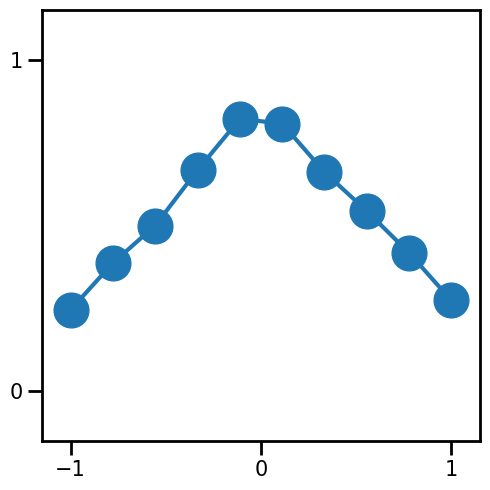

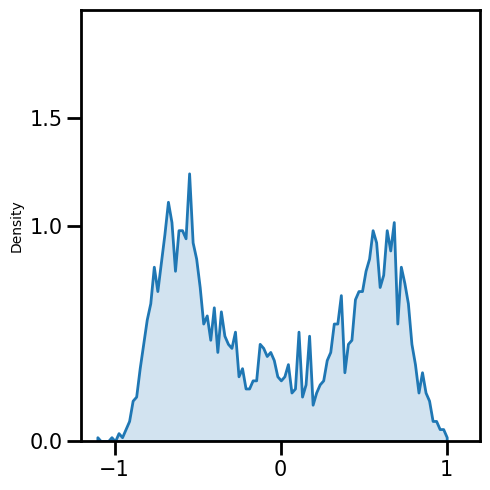

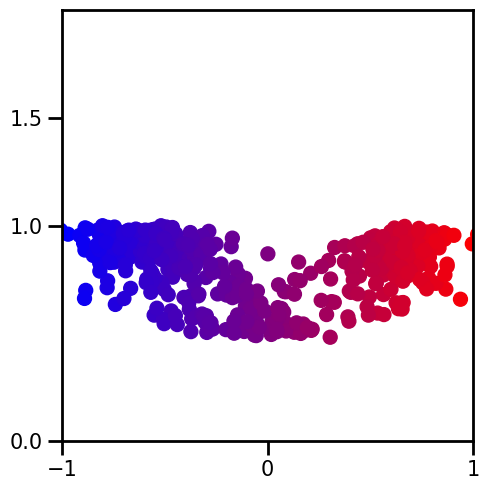

In [11]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list("custom_blue_red",[(0, 0, 1), (1, 0, 0)], N=100)
handle='l1'
%cd '/content/gdrive/MyDrive/UT/Credit-Bias Project/Final Figures/Interval'

fig,ax=plt.subplots(figsize=(5,5))
ax.plot(env.ym.cpu(),C[:,-1,:].mean(dim=1),'-o',linewidth=3,marker=".", markersize=50,alpha=1)
ax.set_xlim([-1.15 ,1.15])
ax.set_ylim([-0.15, 1.15])
ax.set_xticks([-1, 0, 1])
ax.set_yticks([0, 1])
ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
plt.tight_layout()
# plt.savefig(f'xc_{handle}.svg')
plt.show()

fig,ax=plt.subplots(figsize=(5,5))
sns.histplot(X[:,-1,:].flatten().cpu().numpy(),
             bins=100, element="poly", stat="density",alpha=.2,linewidth=2)
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(0, 2)
ax.set_xticks([-1, 0, 1])
ax.set_yticks([0,1 ,1.5])
ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
# ax.set_xlabel('Opinion',fontsize=15)
# ax.set_ylabel('Credibility',fontsize=15)
plt.tight_layout()
# plt.savefig(f"Dist_{handle}.svg",dpi=300)
plt.show()



fig,ax=plt.subplots(figsize=(5,5))
x=env.X.squeeze().cpu().numpy()[-1,:]
ax.scatter(y=env.AEm.sum(axis=2).cpu().flatten().numpy()/(terminal_time-1),x=x,c=x,cmap=cmap,s=100,alpha=1)
ax.set_xlim(-1, 1)
ax.set_ylim(0, 2)
ax.set_xticks([-1, 0, 1])
ax.set_yticks([0,1 ,1.5])
ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
# ax.set_xlabel('Opinion',fontsize=15)
# ax.set_ylabel('Credibility',fontsize=15)
plt.tight_layout()
# plt.savefig(f"Ex_{handle}.svg",dpi=300)
plt.show()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/UT/Credit-Bias Project/Final Figures/Interval


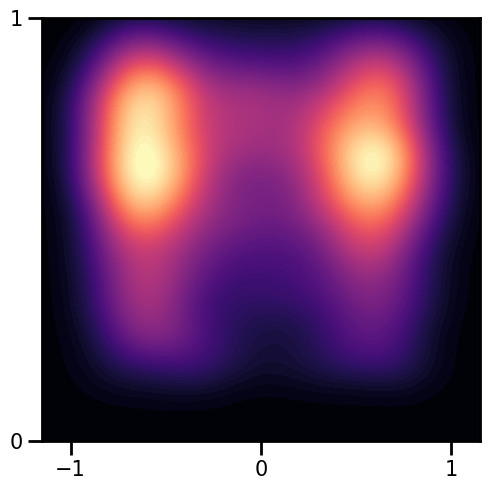

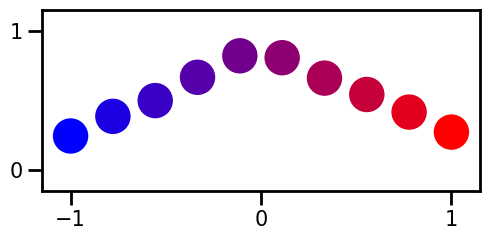

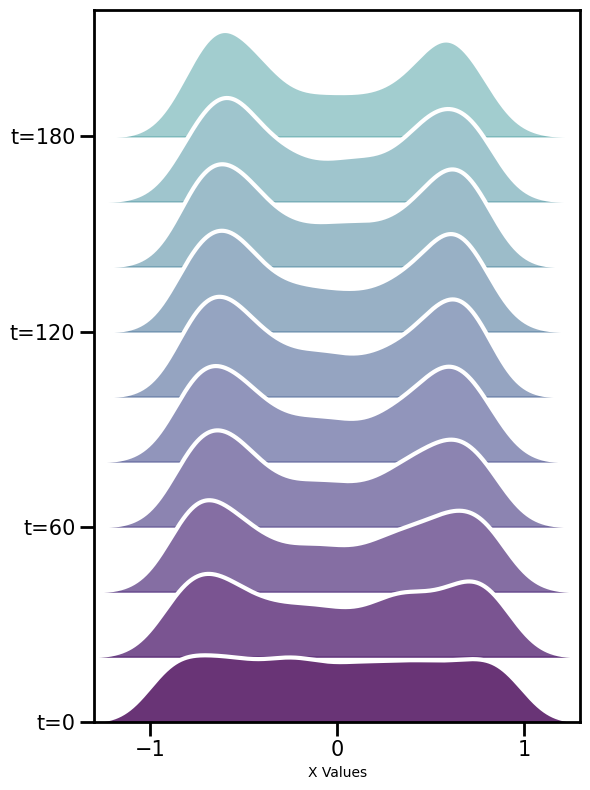

In [12]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/UT/Credit-Bias Project/Final Figures/Interval'

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list("custom_blue_red",[(0, 0, 1), (1, 0, 0)], N=100)

x_all=X[:,-1,:].flatten().cpu().numpy()
s_all=env.s.squeeze().repeat(rep).cpu().numpy()
if 1:
    fig, axes = plt.subplots(1, 1, figsize=(1*5, 5))  # Adjust the figure size as needed
    ax=axes
    sns.kdeplot(x=x_all, y=s_all, fill=True, thresh=None, cmap="magma", levels=100, ax=ax)
    ax.set_xlim(-1.15, 1.15)
    ax.set_ylim(0, 1)
    ax.set_xticks([-1, 0, 1])
    ax.set_yticks([0, 1])
    ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
    ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)

plt.tight_layout()
plt.savefig('xs200-9action_b10.svg')
plt.show()

fig,ax=plt.subplots(figsize=(5,2.5))
ax.scatter(env.ym.cpu(),C[:,-1,:].mean(dim=1),600,c=env.ym.cpu(),cmap=cmap,alpha=1)
ax.set_xlim([-1.15 ,1.15])
ax.set_ylim([-0.15, 1.15])
ax.set_xticks([-1, 0, 1])
ax.set_yticks([0, 1])
ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
plt.tight_layout()
plt.savefig('xc200-9action_b10.svg')
plt.show()



# Create the plot
fig, ax = plt.subplots(figsize=(6, 8))

# Define a colormap
cmap = plt.get_cmap("viridis")
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

# Variables to control the vertical placement and scaling of KDEs
vertical_shift = 0.18 # Controls the vertical spacing between plots
scale_factor = 0.35   # Controls the height of each KDE plot
yp=0
# Plot KDE for t = 0, 10, ..., 200 with different colors and vertical shifts
for idx, t in enumerate(range(0, 200, 20)):
    data = X[:, t, :].flatten()
    kde = stats.gaussian_kde(data)
    x = np.linspace(-1.3, 1.3, 1000)
    y = kde(x) * scale_factor + idx * vertical_shift  # Scale and shift the KDE plot
    ax.fill_between(x, np.maximum(idx * vertical_shift,yp), y, color=colors[idx], alpha=8/(idx+10))
    ax.plot(x, y, color='white', linewidth=3)  # Add line for better visual separation
    yp=y

# Customize the plot
ax.set_xlim([-1.3, 1.3])
ax.set_ylim([0, idx * vertical_shift + scale_factor])
ax.set_yticks([i * vertical_shift for i in range(10)])  # Set y-ticks to match the shifted plots
ax.set_yticklabels([f't={t}' for t in range(0, 200, 20)])  # Label y-ticks with values of t
ax.set_xlabel('X Values')
ax.grid(False)  # Turn off the grid for a cleaner look


ax.set_xticks([-1, 0, 1])
ax.set_yticks([0, 3*vertical_shift,6*vertical_shift,9*vertical_shift])
ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)

plt.tight_layout()
plt.savefig('xt200-9action_b10.svg')
plt.show()

action u:6,	 v:1,	 reward: -0.15089663863182068
action u:3,	 v:7,	 reward: -0.17607381939888
action u:5,	 v:1,	 reward: -0.1365198791027069
action u:8,	 v:1,	 reward: -0.1275831013917923
action u:5,	 v:1,	 reward: -0.12563461065292358
action u:8,	 v:7,	 reward: -0.18511536717414856
action u:4,	 v:1,	 reward: -0.1817259043455124
action u:8,	 v:1,	 reward: -0.17731541395187378
action u:5,	 v:1,	 reward: -0.21716700494289398
action u:6,	 v:7,	 reward: -0.25471705198287964
action u:5,	 v:1,	 reward: -0.236599862575531
action u:5,	 v:0,	 reward: -0.23504722118377686
action u:3,	 v:7,	 reward: -0.24652054905891418
action u:5,	 v:7,	 reward: -0.1991197168827057
action u:6,	 v:1,	 reward: -0.22571247816085815
action u:8,	 v:1,	 reward: -0.22644981741905212
action u:4,	 v:7,	 reward: -0.2475256621837616
action u:5,	 v:1,	 reward: -0.22618548572063446


KeyboardInterrupt: 

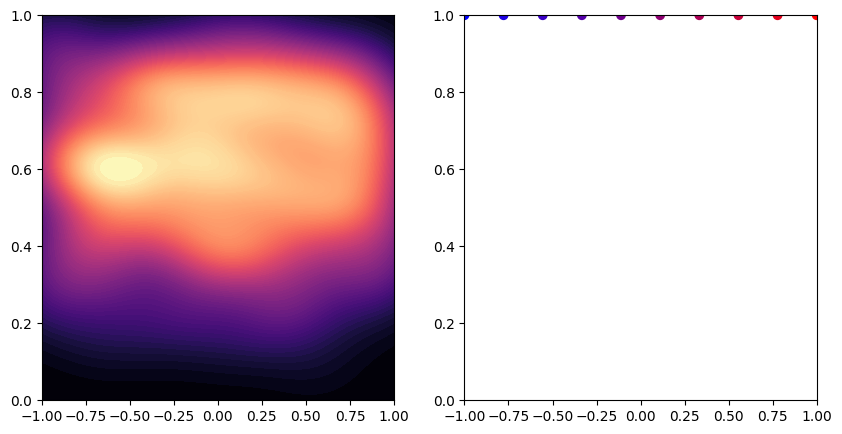

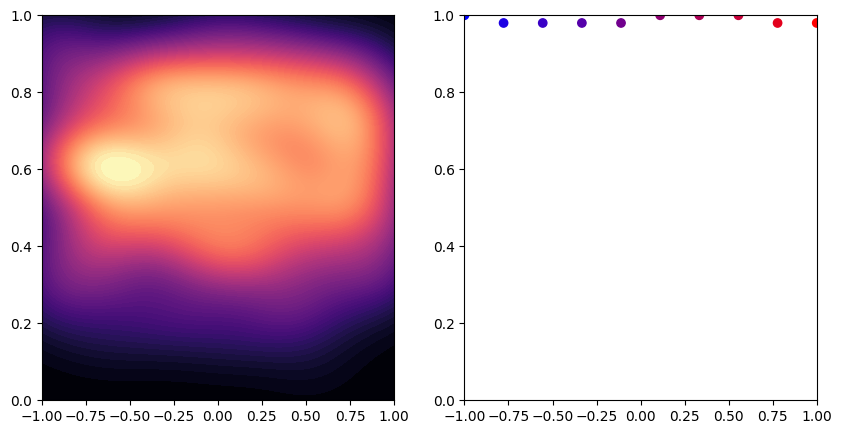

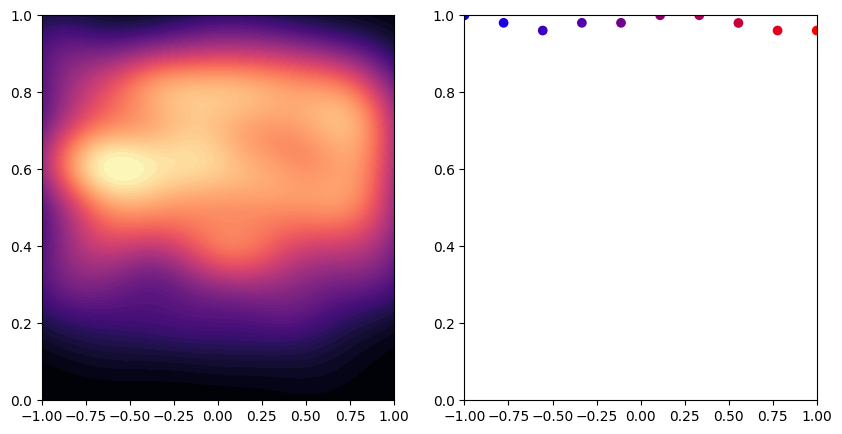

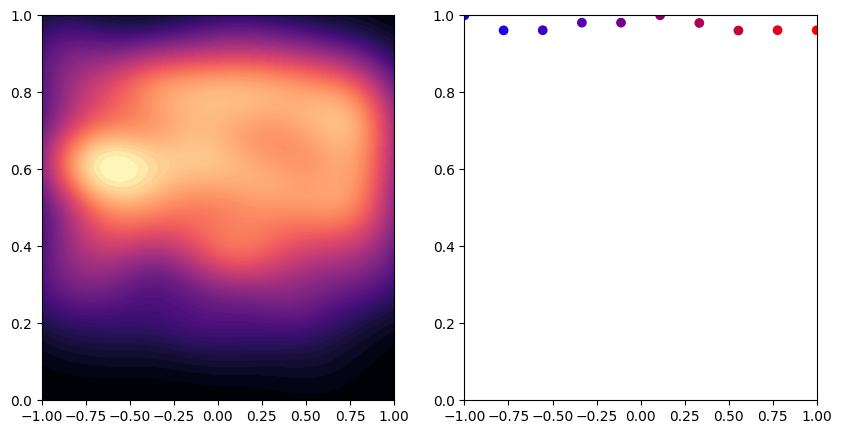

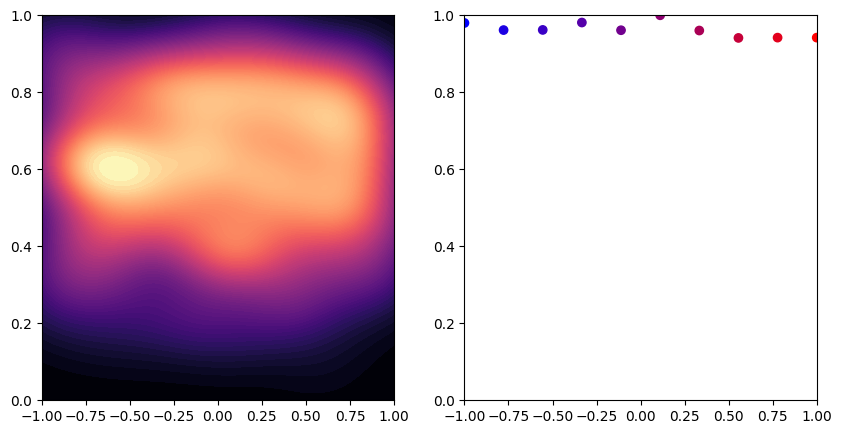

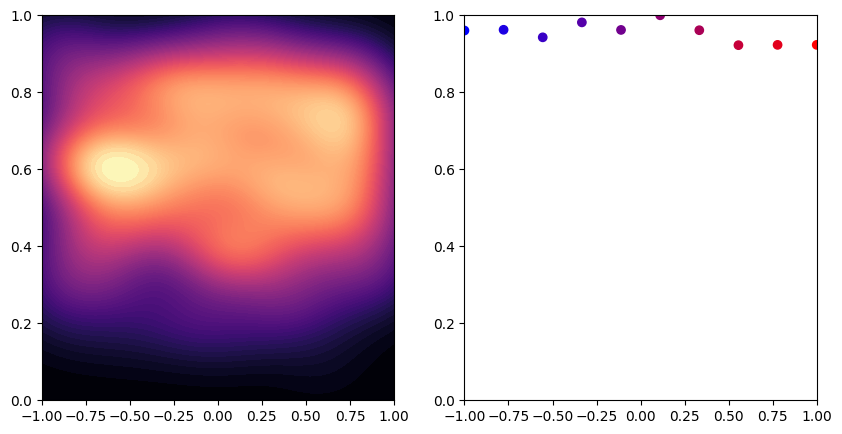

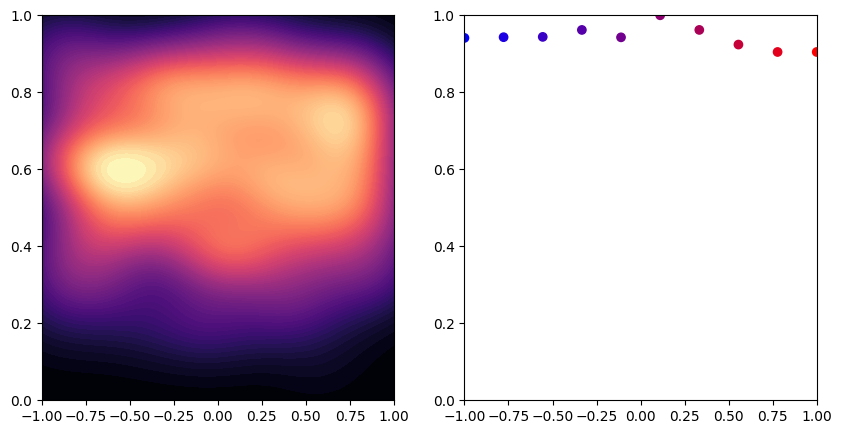

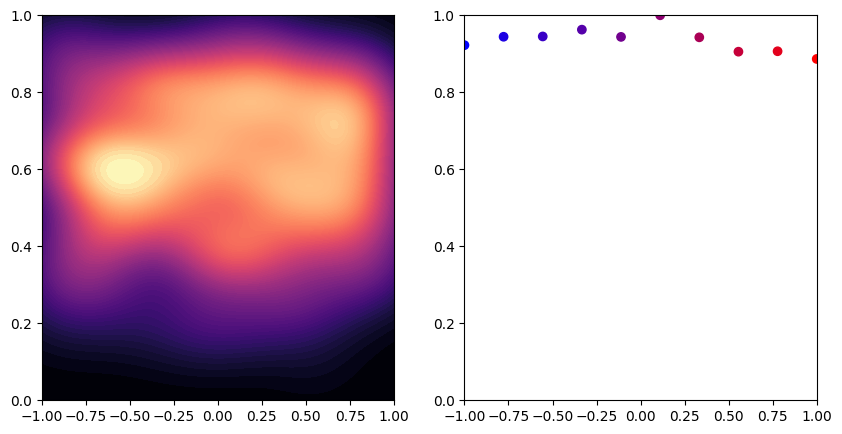

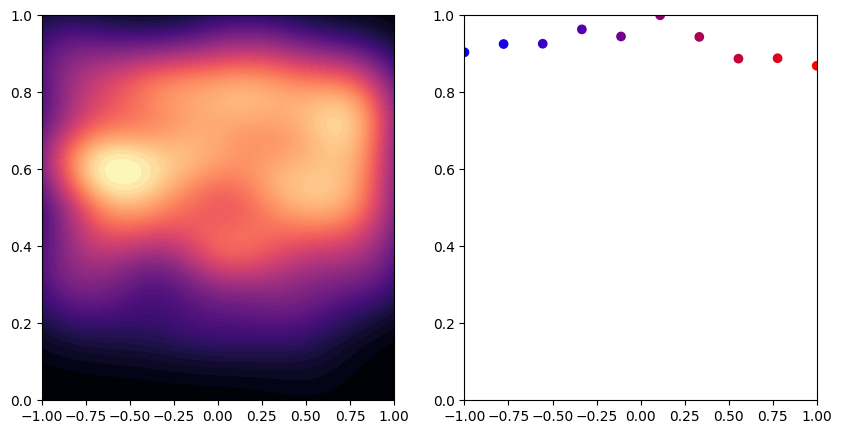

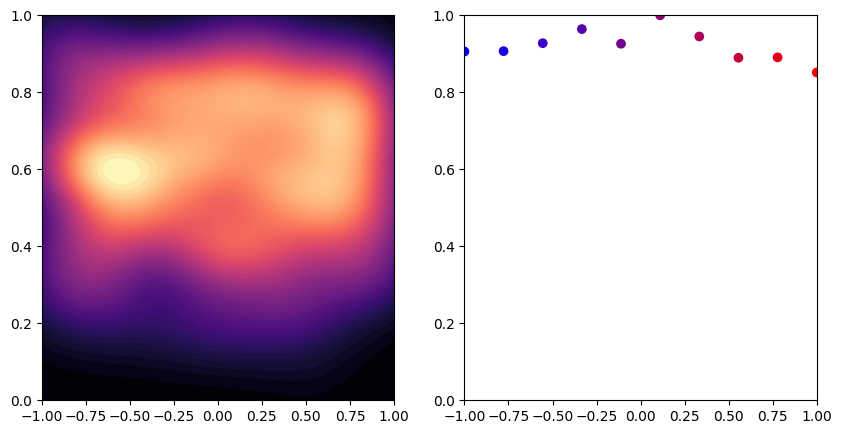

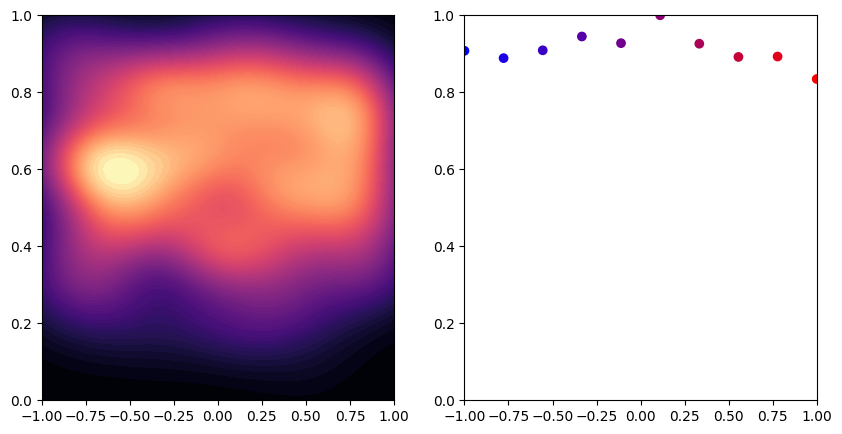

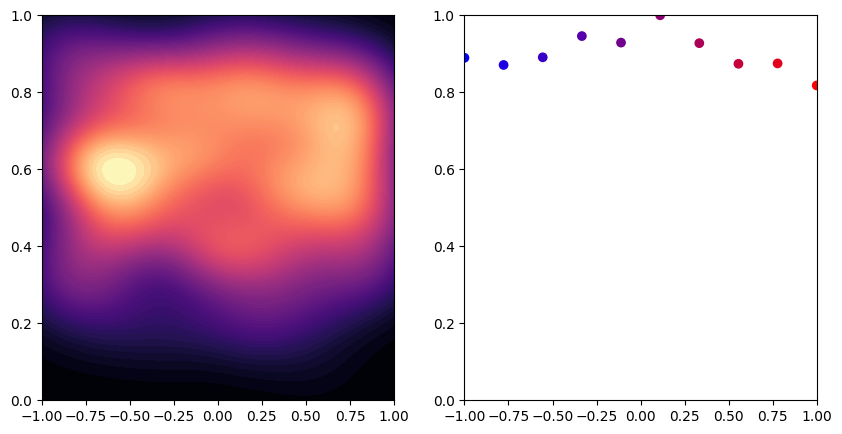

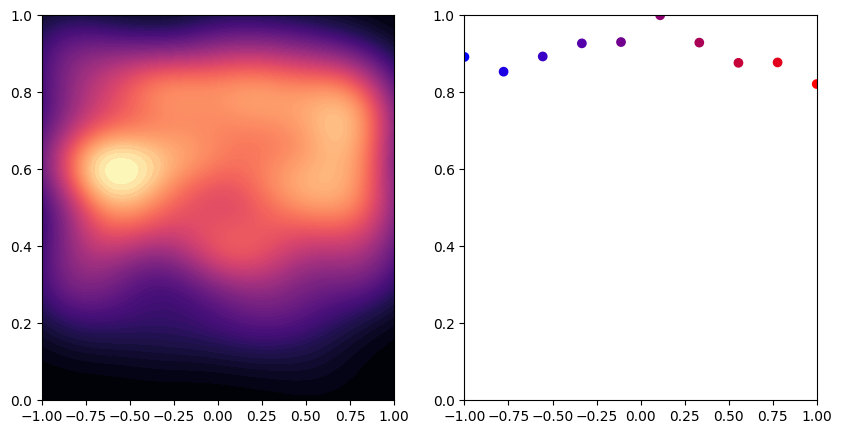

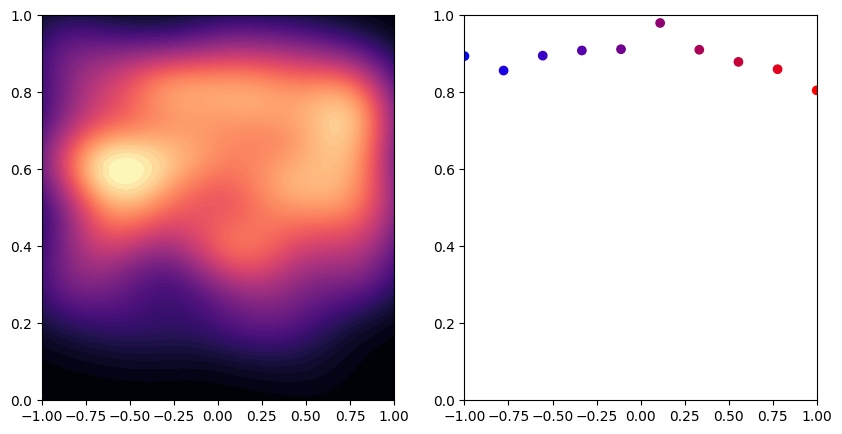

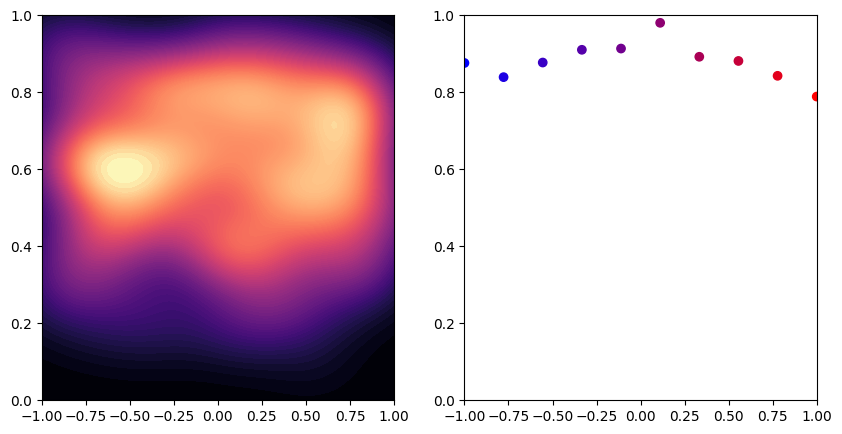

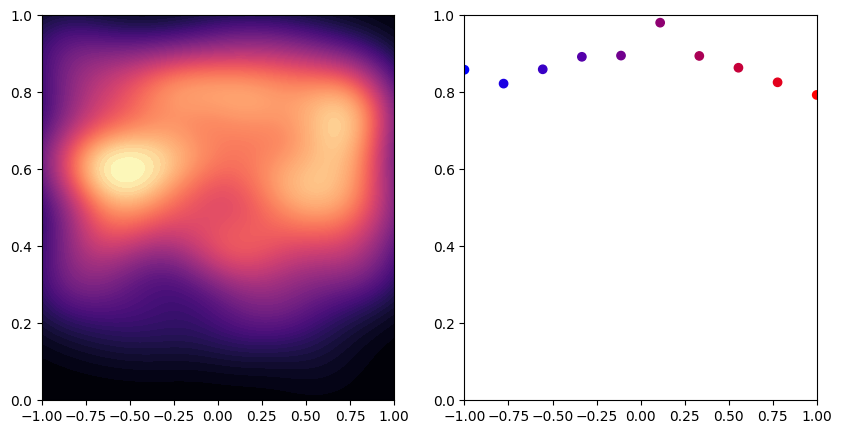

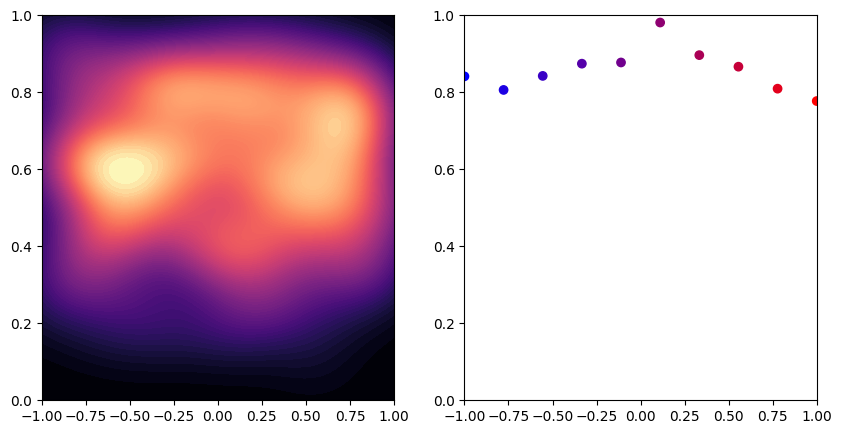

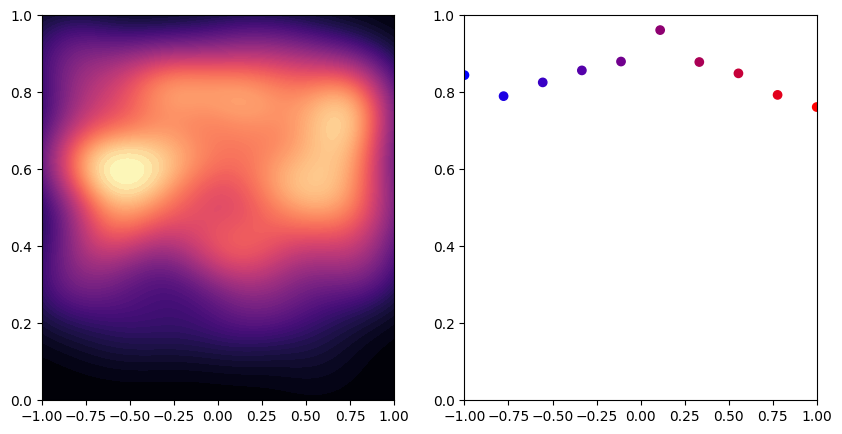

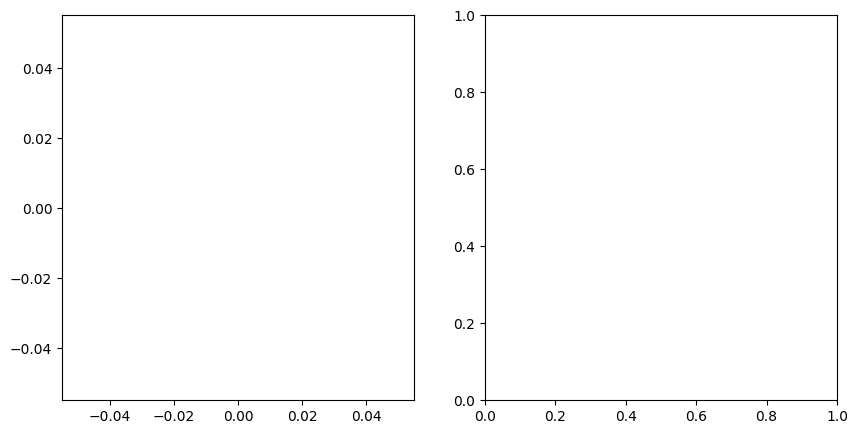

In [ ]:
import seaborn as sns
xct=env.reset()
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[1].scatter(x=np.linspace(-1, 1, env.M), y=env.state[env.N:].cpu().squeeze().numpy(), c=np.linspace(-1, 1, env.M), cmap=cmap)
ax[0].set_ylim(0, 1)
ax[0].set_xlim(-1, 1)
ax[1].set_ylim(0, 1)
ax[1].set_xlim(-1, 1)
sns.kdeplot(x=env.state[:env.N].cpu().squeeze().numpy(), y=env.s.squeeze().cpu().numpy(), ax=ax[0],fill=True,thresh=None,levels=100,cmap='magma')


obs = env.state2obs(xct)
reward_total=0
while True:
    # u_action, v_action,action_id,action_dist = eval_net.act(obs.t())
    u_action, v_action,action_id,action_dist = target_net.act(obs.t())
    # if np.random.rand()<0.99:
    #     # v_action=np.random.randint(0,9)
    #     v_action=7
    count += 1
    reward, Done  =env.dyn_step(torch.tensor(u_action,device=env.device),torch.tensor(v_action,device=env.device))
    next_obs = env.state2obs(env.state)
    buffer.store(obs, action_id, reward, next_obs, Done)
    reward_total =reward_total + reward
    print(f'action u:{u_action},\t v:{v_action},\t reward: {reward}')
    obs = next_obs
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.kdeplot(x=env.state[:env.N].cpu().squeeze().numpy(), y=env.s.squeeze().cpu().numpy(), ax=ax[0],fill=True,thresh=None,levels=100,cmap='magma')
    ax[1].scatter(x=np.linspace(-1, 1, env.M), y=env.state[env.N:].cpu().squeeze().numpy(), c=np.linspace(-1, 1, env.M), cmap=cmap)
    ax[0].set_ylim(0, 1)
    ax[0].set_xlim(-1, 1)
    ax[1].set_ylim(0, 1)
    ax[1].set_xlim(-1, 1)

    if Done:
        break


print(reward_total)


import matplotlib.pyplot as plt
import numpy as np
fig,ax=plt.subplots(figsize=(7,5))
# Convert env.C and env.ym to numpy arrays if they are tensors
C = env.C.squeeze().numpy() if hasattr(env.C.squeeze(), 'numpy') else env.C.squeeze()
ym = env.ym.numpy() if hasattr(env.ym, 'numpy') else env.ym

# Ensure ym is in a suitable range for the colormap (0 to 1)
norm = plt.Normalize(ym.min(), ym.max())
cmap = LinearSegmentedColormap.from_list("custom_blue_red", [(0, 0, 1), (1, 0, 0)], N=100)
# Plot each line with a color based on ym
for i in range(C.shape[1]):
    ax.plot(C[:, i], color=cmap(norm(ym[i])),linewidth=2)

plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label='ym values')
plt.tight_layout()
plt.show()

fig,ax=plt.subplots(figsize=(5,5))
x=env.X.squeeze().cpu().numpy()[-1,:]
ax.scatter(y=env.AEm.sum(axis=2).cpu().flatten().numpy()/(terminal_time-1),x=x,c=x,cmap=cmap,s=100,alpha=1)
ax.set_xlim(-1, 1)
ax.set_ylim(0, 1)
ax.set_xticks([-1, 0, 1])
ax.set_yticks([0,1 ,1.5])
ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.set_xlabel('Opinion',fontsize=15)
ax.set_ylabel('Credibility',fontsize=15)
plt.tight_layout()
# plt.savefig("Ex_"+plt_type+".svg",dpi=300)
plt.show()



# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# sns.kdeplot(x=env.state[:env.N].cpu().squeeze().numpy(), y=env.s.squeeze().cpu().numpy(), ax=ax[0],fill=True,thresh=None,levels=100,cmap='magma')
# sns.jointplot(x=env.state[:env.N].cpu().squeeze().numpy(), y=env.s.squeeze().cpu().numpy(), ax=ax[1],cmap='magma')
# ax[1].scatter(x=np.linspace(-1, 1, env.M), y=env.state[env.N:].cpu().squeeze().numpy(), c=env.state[env.N:].cpu().squeeze().numpy(), cmap=cmap)